In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import optuna
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import AUC
import random

random.seed(123)
np.random.seed(123)
tf.random.set_seed(123)

/opt/anaconda3/envs/jason/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
t = pd.read_csv('/Users/jason/msa/main/Machine Learning/hw/Homework3_ML/insurance_t.csv')
v = pd.read_csv('/Users/jason/msa/main/Machine Learning/hw/Homework3_ML/insurance_v.csv')
print("training has " + str(len(t)) + "\nvalid has " + str(len(v)))
data = pd.concat([t, v], axis = 0)

for cols in data.columns:
    if(data[str(cols)].nunique() < 10):
        data[str(cols)] = data[str(cols)].astype('category')
    
data['BRANCH'] = data['BRANCH'].astype('category')

for cols in data.columns:
    if(data[str(cols)].dtype == "category"):
        data[str(cols)] = data[str(cols)].fillna(data[str(cols)].mode()[0])
    else:
        data[str(cols)] = data[str(cols)].fillna(data[str(cols)].median())
        


training has 8495
valid has 2124


In [3]:
dataY = pd.DataFrame(data['INS']).values.ravel()
dataX = data.drop(['INS'], axis=1)
dataX = pd.get_dummies(dataX, columns=['BRANCH'], drop_first=True).astype(int)
xTrain = dataX[0:8495]
xValid = dataX[8495:]
yTrain = dataY[0:8495]
yValid = dataY[8495:]


In [ ]:
def objective(trial):
    batch_size = trial.suggest_categorical('batch_size', [16,32,64,128,256])
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log = True)
    num_layers = trial.suggest_int('num_layers', 1,3)
    units_per_layer = trial.suggest_categorical('units_per_layer', [32,64,128,256,512])
    dropout_rate = trial.suggest_float('dropout_rate', 0.2, 0.3)
    optimizer_choice = trial.suggest_categorical('optimizer', ['adam', 'rmsprop'])
    activation_function = trial.suggest_categorical('activation_function', ['relu', 'leaky_relu', 'tanh'])
    scaler_choice = trial.suggest_categorical('scaler', ['StandardScaler', 'RobustScaler'])
    
    if scaler_choice == 'StandardScaler':
        scaler = StandardScaler()
    else:
        scaler = RobustScaler()
    
    scaler.fit(xTrain)    
    xTrainS = scaler.transform(xTrain)

    def create_model(input_dim = dataX.shape[1]):
        model = Sequential()
        model.add(Input(shape = (input_dim,)))
        for _ in range (num_layers) : 
            model.add(Dense(units_per_layer, activation = activation_function))
            model.add(tf.keras.layers.Dropout(dropout_rate))
            
        model.add(Dense(1, activation = 'sigmoid'))
        
        if optimizer_choice == 'adam':
            optimizer = Adam(learning_rate=learning_rate)
        else:
            optimizer = RMSprop(learning_rate=learning_rate)
        
        model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
        return model
    
    model = create_model()
    
    kfold = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 123)
    auc_scores = []
    
    for train_index, test_index in kfold.split(np.array(xTrainS), np.array(yTrain)):
        x_cv_train, x_cv_test, = xTrainS[train_index], xTrainS[test_index]
        y_cv_train, y_cv_test, = yTrain[train_index], yTrain[test_index]
        
        model.fit(x_cv_train, y_cv_train, batch_size = batch_size, verbose = 0)
        y_pred_proba = model.predict(x_cv_test, verbose = 0)
        
        auc_scores.append(roc_auc_score(y_cv_test, y_pred_proba))
        
    return np.mean(auc_scores)

In [12]:
study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 500)

best_trial = study.best_trial
print("Best hyperparameters:")
for key, value in best_trial.params.items():
    print(f"{key}: {value}")


[I 2024-11-25 10:45:23,896] A new study created in memory with name: no-name-aa889a57-dfea-438a-8ccc-aa5cf56e3cb0


[I 2024-11-25 10:45:28,036] Trial 0 finished with value: 0.7113165648923994 and parameters: {'batch_size': 128, 'learning_rate': 2.5567834403941968e-05, 'num_layers': 3, 'units_per_layer': 256, 'dropout_rate': 0.20303677909470225, 'optimizer': 'rmsprop', 'activation_function': 'leaky_relu', 'scaler': 'StandardScaler'}. Best is trial 0 with value: 0.7113165648923994.
[I 2024-11-25 10:45:34,227] Trial 1 finished with value: 0.5979851727530764 and parameters: {'batch_size': 32, 'learning_rate': 3.8764844093740085e-05, 'num_layers': 3, 'units_per_layer': 256, 'dropout_rate': 0.23026320275061365, 'optimizer': 'rmsprop', 'activation_function': 'leaky_relu', 'scaler': 'RobustScaler'}. Best is trial 0 with value: 0.7113165648923994.
[I 2024-11-25 10:45:37,935] Trial 2 finished with value: 0.7408352419239252 and parameters: {'batch_size': 16, 'learning_rate': 0.006848369475108668, 'num_layers': 1, 'units_per_layer': 64, 'dropout_rate': 0.2683430661274238, 'optimizer': 'rmsprop', 'activation_fun

KeyboardInterrupt: 

In [ ]:
best_params = study.best_params
print(best_params)
#{'batch_size': 64, 'learning_rate': 0.0010942664184895958, 'num_layers': 2, 'units_per_layer': 512, 'dropout_rate': 0.2249188944046662, 'optimizer': 'rmsprop', 'activation_function': 'relu', 'scaler': 'StandardScaler'}


{'batch_size': 64, 'learning_rate': 0.0010942664184895958, 'num_layers': 2, 'units_per_layer': 512, 'dropout_rate': 0.2249188944046662, 'optimizer': 'rmsprop', 'activation_function': 'relu', 'scaler': 'StandardScaler'}


In [14]:
if best_params['scaler'] == 'StandardScaler':
        scaler = StandardScaler()
else:
        scaler = RobustScaler()

scaler.fit(xTrain)
xTrainS = scaler.transform(xTrain)
xTrainS = np.array(xTrainS, dtype=np.float32)
yTrain = np.array(yTrain, dtype=np.float32)

In [15]:
def final_model(input_dim=dataX.shape[1]):
    model = Sequential()
    model.add(Input(shape=(input_dim,)))
    
    for _ in range(best_params['num_layers']):
        model.add(Dense(best_params['units_per_layer'], activation=best_params['activation_function']))
        model.add(tf.keras.layers.Dropout(best_params['dropout_rate']))
    
    model.add(Dense(1, activation='sigmoid'))
    
    if best_params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=best_params['learning_rate'])
    else:
        optimizer = RMSprop(learning_rate=best_params['learning_rate'])
    
    model.compile(optimizer=optimizer, 
                  loss='binary_crossentropy', 
                  metrics=['accuracy', AUC(name='auc')])
    return model

model = final_model()


early_stopping = EarlyStopping(
    monitor='val_auc',            # Monitor AUC on the validation set
    mode='max',                   # Stop when AUC stops improving
    patience=5,                  # Number of epochs to wait for improvement
    restore_best_weights=True     # Revert to the best model weights
)

history = model.fit(
    xTrainS, yTrain,
    validation_split=0.3,         # Reserve 20% of data for validation
    batch_size=best_params['batch_size'],
    epochs=100,                   # Start with a high maximum
    callbacks=[early_stopping],   # Include early stopping
    verbose=1
)


Epoch 1/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6906 - auc: 0.6879 - loss: 0.5996 - val_accuracy: 0.7293 - val_auc: 0.7545 - val_loss: 0.5593
Epoch 2/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7447 - auc: 0.7796 - loss: 0.5279 - val_accuracy: 0.7305 - val_auc: 0.7630 - val_loss: 0.5473
Epoch 3/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7638 - auc: 0.8071 - loss: 0.4997 - val_accuracy: 0.7328 - val_auc: 0.7623 - val_loss: 0.5489
Epoch 4/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7767 - auc: 0.8194 - loss: 0.4864 - val_accuracy: 0.7262 - val_auc: 0.7625 - val_loss: 0.5503
Epoch 5/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7820 - auc: 0.8282 - loss: 0.4743 - val_accuracy: 0.7207 - val_auc: 0.7600 - val_loss: 0.5547
Epoch 6/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7834 - auc: 0.8343 - loss: 0.4662 - val_accuracy: 0.7222 - val_auc: 0.7545 - val_loss: 0.5605
Epoch 7/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
AUC: 0.7636316561411447
Optimal Threshold: 0.37158158


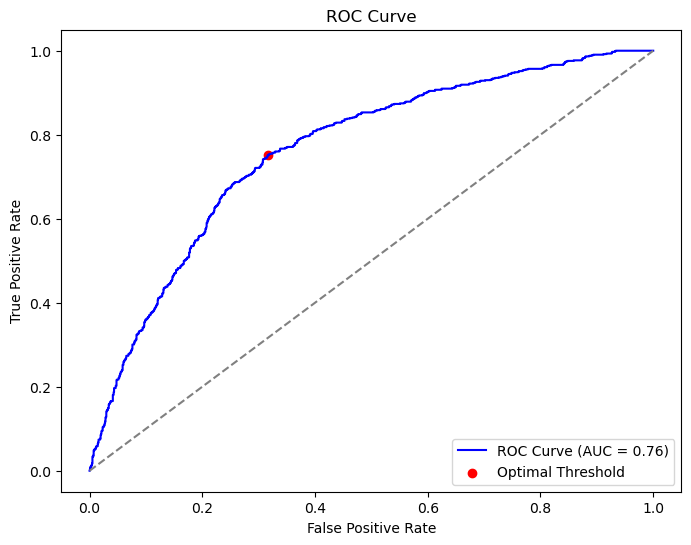

In [16]:
xValidS = scaler.transform(xValid)
y_pred_prob = model.predict(xValidS)
fpr, tpr, thresholds = roc_curve(yValid, y_pred_prob)
auc = roc_auc_score(yValid, y_pred_prob)
print("AUC:", auc)

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Optimal Threshold:", optimal_threshold)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='ROC Curve (AUC = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], marker='o', color='red', label='Optimal Threshold')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()


In [17]:

y_pred_classes = (y_pred_prob > optimal_threshold).astype(int)  # Apply a threshold for binary classification

accuracy = accuracy_score(yValid, y_pred_classes)
auc = roc_auc_score(yValid, y_pred_prob)

print(f"Accuracy: {accuracy}")
print(f"AUC: {auc}")

Accuracy: 0.7071563088512242
AUC: 0.7636316561411447
